### Notas de aula de Computação Quântica <br> Autor: Jonas Maziero

# Correção de erros quânticos - Phase flip

In [42]:
import math
import numpy as np
from qiskit import *
nshots = 8192
qiskit.IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
#device = provider.get_backend('ibmq_jakarta')
provider = qiskit.IBMQ.get_provider(hub = 'ibm-q-research-2', group = 'federal-uni-sant-1', project = 'main')
device = provider.get_backend('ibmq_bogota')
simulator = Aer.get_backend('qasm_simulator')
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.tools.monitor import backend_overview, backend_monitor
from qiskit.tools.visualization import plot_histogram

ibmqfactory.load_account:WARNING:2022-01-31 14:36:25,462: Credentials are already in use. The existing account in the session will be replaced.


O erro de inversão de fase atua como segue
$$|0\rangle\rightarrow |0\rangle,\ |1\rangle\rightarrow -|1\rangle.$$
De forma geral, este erro é descrito pelo chamado canal de phase flip:
$$\Lambda_{bf}(\rho) = (1-p)\rho +pZ\rho Z.$$

É importante aqui perceber que o operador que leva ao phase flip na base computacional é o operador que leva ao bit flip na base de autovetores de $X$, i.e.,
$$Z|+\rangle = |-\rangle,\ Z|-\rangle = |+\rangle.$$
Isso nos indica que podemos usar aqui o código para correção de erros de bit flip, com agumas adaptações.

Com relação à codificação, prepararemos o estado 
$$c_{0}|+++\rangle+c_{1}|---\rangle,$$
pois assim identificaremos o erro de phase flip como fizemos para o bit flip. O circuito para codificação está mostrado abaixo, junto com a parte do erro de phase flip.

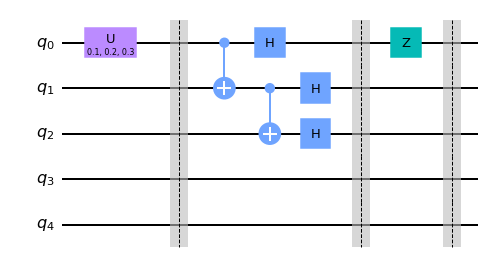

In [43]:
qc = QuantumCircuit(5)
th, ph, lb = 0.1, 0.2, 0.3; qc.u(th, ph, lb, [0]); qc.barrier() # qubit estate preparation
qc.cx([0],[1]); qc.cx([1], [2]); qc.h([0, 1, 2]); qc.barrier() # encoding
qc.z([0]); qc.barrier() # phase flip error
qc.draw(output = 'mpl')

Uma vez que o estado codificado é $c_{0}|+++\rangle+c_{1}|---\rangle,$ podemos identificar a ocorrência de uma inversão de fase através de medidas de paridade dos observáveis $X_{0}X_{1}$ e $X_{1}X_{2}$. Fazemos isso aplicando portas de Hadamard em cada qubit e depois medindo $Z_{0}Z_{1}$ e $Z_{1}Z_{2}$. Veja o circuito quântico abaixo. 

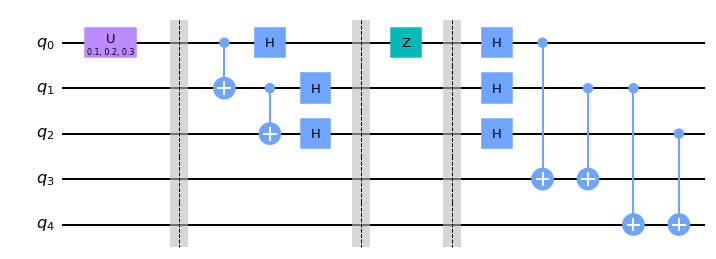

In [44]:
qc.h([0, 1, 2]); qc.cx([0], [3]); qc.cx([1], [3]); qc.cx([1], [4]); qc.cx([2], [4])
qc.draw(output = 'mpl')

Como as portas de Hadamard depois do erro levam o estado novamente para a base computacional, e.g., 
$$c_{0}|+-+\rangle+c_{1}|-+-\rangle\ \xrightarrow[]{H\otimes H\otimes H} c_{0}|010\rangle+c_{1}|101\rangle,$$
O resto do protocolo é o mesmo que para o caso do bit flip. O protocolo completo para correção do erro de inversão de fase está mostrado abaixo.

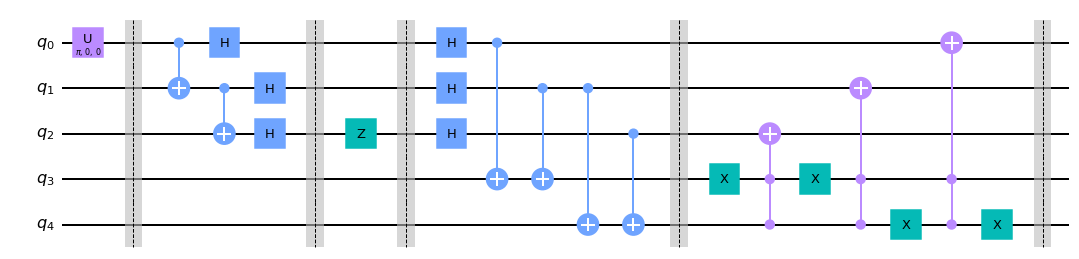

In [45]:
def qc_ec_pf(th, ph, lb, j):
    qc = QuantumCircuit(5, name = 'EC_PF')
    qc.u(th, ph, lb, [0]) # qubit state preparation
    qc.barrier()
    qc.cx([0], [1]); qc.cx([1], [2]); qc.h([0, 1, 2]) # encoding
    qc.barrier()
    if j == 0 or j == 1 or j == 2:  # error
        qc.z([j])
    qc.barrier() 
    qc.h([0, 1, 2]); qc.cx([0], [3]); qc.cx([1], [3]); qc.cx([1], [4]); qc.cx([2], [4]) # syndrome detection
    qc.barrier()
    qc.x([3]); qc.ccx([4], [3], [2]); qc.x([3]); qc.ccx([4], [3], [1]) # correction
    qc.x([4]); qc.ccx([4], [3], [0]); qc.x([4]) # correction
    qc.barrier()
    return qc
th, ph, lb = math.pi, 0.0, 0.0; j = 2; qc_ec_pf_ = qc_ec_pf(th, ph, lb, j)
qc_ec_pf_.draw(output = 'mpl')

In [46]:
# Teste da funcionalidade do circuito para correção do phase flip
qc = QuantumCircuit(5, 3); 
j = 2 # sets the error
qc_ec_pf_ = qc_ec_pf(math.pi/2, 0.0, 0.0, j); qc.append(qc_ec_pf_, [0, 1, 2, 3, 4])
qc.measure([0, 1, 2], [0, 1, 2]);
#qc.decompose().draw(output = 'mpl')

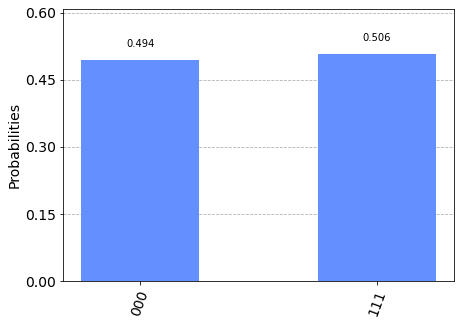

In [47]:
job_sim = execute(qc, backend = simulator, shots = nshots)
plot_histogram(job_sim.result().get_counts(qc))

61f2adb71faa061026348a6f
Job Status: job has successfully run


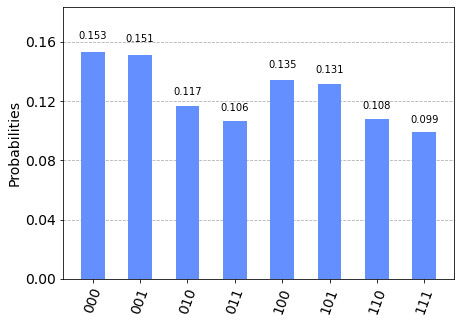

In [30]:
job_exp = execute(qc, backend = device, shots = nshots)
print(job_exp.job_id()); job_monitor(job_exp)
plot_histogram(job_exp.result().get_counts(qc))

## Mitigação do erro de phase flip
### Código de 2 qubits para o phase flip

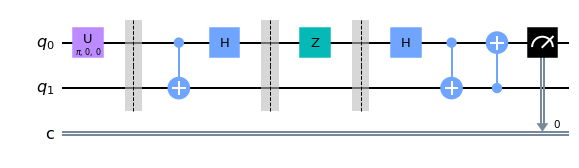

In [48]:
qc = QuantumCircuit(2, 1)
th, ph, lb = math.pi, 0.0, 0.0; qc.u(th, ph, lb, [0]) # state preparation
qc.barrier(); qc.cx([0], [1]); qc.h([0]); qc.barrier()
qc.z([0]); qc.barrier()
qc.h([0]); qc.cx([0], [1]); qc.cx([1], [0])
qc.measure([0], [0])
qc.draw(output = 'mpl')

Contas
\begin{align}
& |\psi\rangle|0\rangle \xrightarrow[]{C_{x}^{01}} c_{0}|00\rangle + c_{1}|11\rangle \\
& \xrightarrow[]{H_{0}} c_{0}|+0\rangle + c_{1}|-1\rangle \\
& \xrightarrow[]{Z_{0}} c_{0}|-0\rangle + c_{1}|+1\rangle \\
& \xrightarrow[]{H_{0}} c_{0}|10\rangle + c_{1}|01\rangle \\
& \xrightarrow[]{C_{x}^{01}} c_{0}|11\rangle + c_{1}|01\rangle = (c_{0}|1\rangle + c_{1}|0\rangle)|1\rangle \\
& \xrightarrow[]{C_{x}^{10}} (c_{0}|0\rangle + c_{1}|1\rangle)|1\rangle = |\psi\rangle|1\rangle.
\end{align}
No final do dia, o que fazem é transformar o erro de flip de fase em erro de flip de bit.

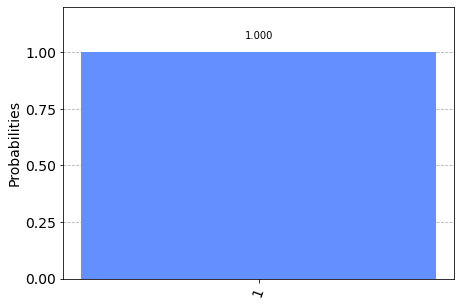

In [49]:
job = execute(qc, backend = simulator, shots = nshots)
plot_histogram(job.result().get_counts(qc))

Job Status: job has successfully run


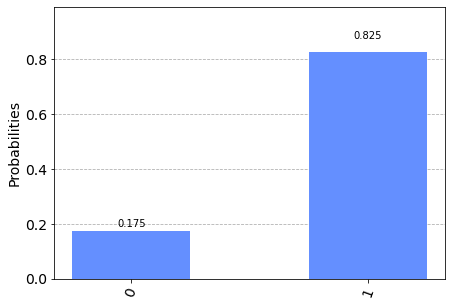

In [10]:
job = execute(qc, backend = device, shots = nshots); job_monitor(job)
plot_histogram(job.result().get_counts(qc))

# Correção de erros quânticos - geral 

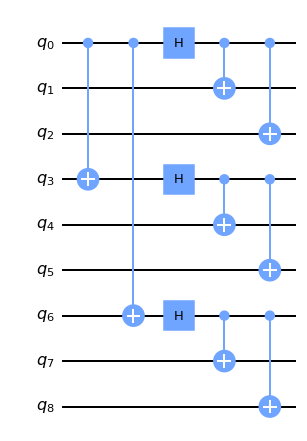

In [50]:
def qc_encoding_shor():
    qc = QuantumCircuit(9, name = 'encoding')
    qc.cx([0], [3]); qc.cx([0], [6])
    qc.h([0, 3, 6])
    qc.cx([0], [1]); qc.cx([0], [2]); qc.cx([3], [4])
    qc.cx([3], [5]); qc.cx([6], [7]); qc.cx([6], [8])
    return qc
qc_encoding_shor_ = qc_encoding_shor(); qc_encoding_shor_.draw(output = 'mpl')

A codificação é feita como segue:
\begin{align}
& |\psi 00000000\rangle \xrightarrow[]{C_{x}^{03}} c_{0}|000000000\rangle + c_{1}|100100000\rangle \xrightarrow[]{C_{x}^{06}} c_{0}|000000000\rangle + c_{1}|100100100\rangle \\
& \xrightarrow[]{H_{0}H_{3}H_{6}} c_{0}|+00+00+00\rangle + c_{1}|-00-00-00\rangle \\
& \xrightarrow[]{C_{x}^{01}C_{x}^{02}C_{x}^{34}C_{x}^{35}C_{x}^{67}C_{x}^{68}} \\
& \frac{c_{0}}{2^{3/2}}(|000\rangle+|111\rangle)(|000\rangle+|111\rangle)(|000\rangle+|111\rangle) + \frac{c_{1}}{2^{3/2}}(|000\rangle-|111\rangle)(|000\rangle-|111\rangle)(|000\rangle-|111\rangle).
\end{align}
Para este estado, vemos que se ocorrer um único erro de bit flip, este mudará a paridade do estado dos qubits dentro de um certo trio de qubits. Por exemplo, se ocorrer uma inversão de bit no qubit 5, o está obtido será
\begin{equation}
\frac{c_{0}}{2^{3/2}}(|000\rangle+|111\rangle)(|010\rangle+|101\rangle)(|000\rangle+|111\rangle) + \frac{c_{1}}{2^{3/2}}(|000\rangle-|111\rangle)(|010\rangle-|101\rangle)(|000\rangle-|111\rangle).
\end{equation}
Na verdade, para esta codificação, mesmo para três inversões de bit, uma em cada trio de qubits, somos capazes de identificar e de corrigir esses erros.

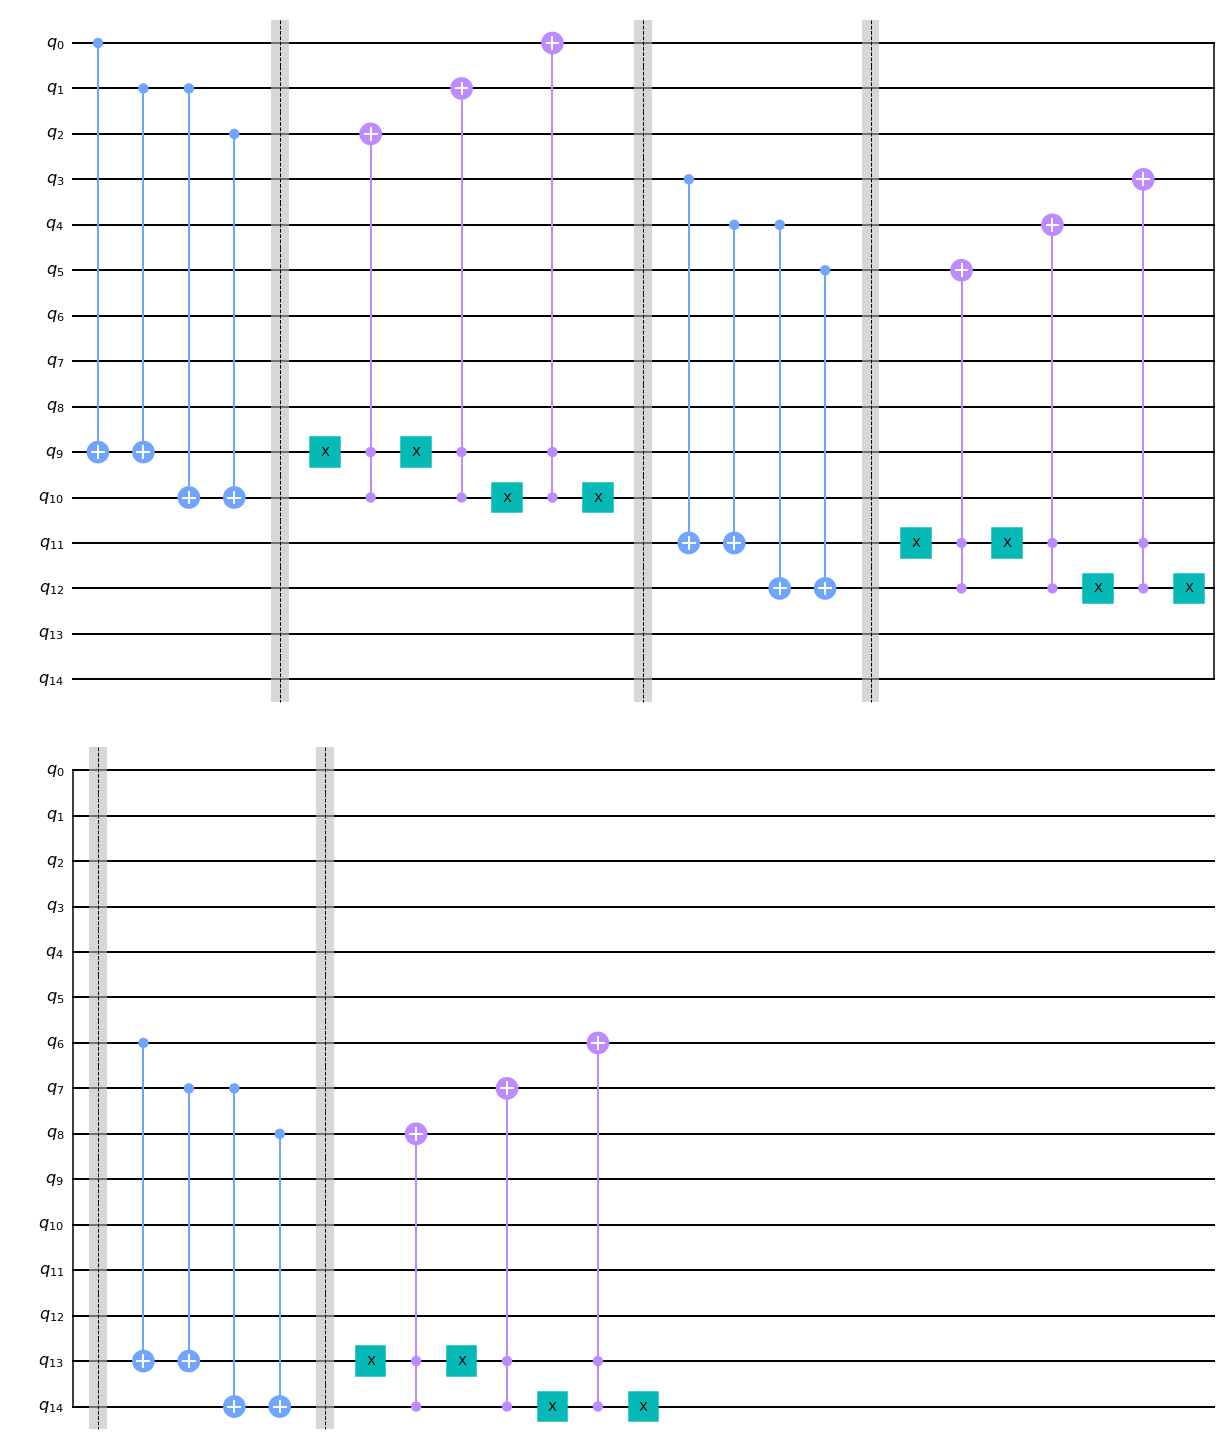

In [68]:
def qc_gen_bf():
    qc = QuantumCircuit(9+6, name = 'BF')
    qc.decompose().draw(output = 'mpl')
    qc.cx([0], [9]); qc.cx([1], [9]); qc.cx([1], [10]); qc.cx([2], [10])
    qc.barrier()
    qc.x([9]); qc.ccx([10], [9], [2]); qc.x([9]); qc.ccx([10], [9], [1]); qc.x([10]); qc.ccx([10], [9], [0]); qc.x([10])
    qc.barrier()
    qc.cx([3], [11]); qc.cx([4], [11]); qc.cx([4], [12]); qc.cx([5], [12])
    qc.barrier()
    qc.x([11]); qc.ccx([12], [11], [5]); qc.x([11]); qc.ccx([12], [11], [4]); qc.x([12]); qc.ccx([12], [11], [3]); qc.x([12])
    qc.barrier()
    qc.cx([6], [13]); qc.cx([7], [13]); qc.cx([7], [14]); qc.cx([8], [14])
    qc.barrier()
    qc.x([13]); qc.ccx([14], [13], [8]); qc.x([13]); qc.ccx([14], [13], [7]); qc.x([14]); qc.ccx([14], [13], [6]); qc.x([14])
    return qc
qc_gen_bf_ = qc_gen_bf(); qc_gen_bf_.draw(output = 'mpl')
#qc.decompose().draw(output = 'mpl')

Nesse ponto, detectamos possíveis erros de inversão de bit e os corrigimos. Passemos agora para o erro de inversão de fase. Notamos prontamente pela forma do estado
\begin{equation}
|\Psi\rangle = \frac{c_{0}}{2^{3/2}}(|000\rangle+|111\rangle)(|000\rangle+|111\rangle)(|000\rangle+|111\rangle) + \frac{c_{1}}{2^{3/2}}(|000\rangle-|111\rangle)(|000\rangle-|111\rangle)(|000\rangle-|111\rangle)
\end{equation}
que um erro de inversão de fase pode ser detectado via a paridade de fase dentre os trios de qubits. Por exemplo, se ocorreu um erro de fase em um dos 3 qubits do 2º trio, o estado do sistema será
\begin{equation}
|\Psi_{bf2}\rangle = \frac{c_{0}}{2^{3/2}}(|000\rangle+|111\rangle)(|000\rangle-|111\rangle)(|000\rangle+|111\rangle) + \frac{c_{1}}{2^{3/2}}(|000\rangle-|111\rangle)(|000\rangle+|111\rangle)(|000\rangle-|111\rangle)
\end{equation}
Podemos então detectar esse erro medindo a paridade de fase entre os trios de qubits. Mas como fazer isso? 

Primeiramente, notemos que 
\begin{align}
& (|000\rangle+|111\rangle)/\sqrt{2} \xrightarrow[]{C_{x}^{01}C_{x}^{02}} |+00\rangle \xrightarrow[]{H_{0}} |000\rangle, \\
& (|000\rangle-|111\rangle)/\sqrt{2} \xrightarrow[]{C_{x}^{01}C_{x}^{02}} |-00\rangle \xrightarrow[]{H_{0}} |100\rangle.
\end{align}
Assim, para o estado considerado como exemplo acima, teremos
\begin{equation}
|\Psi_{bf2}\rangle \xrightarrow[]{H_{0}H_{3}H_{6}C_{x}^{01}C_{x}^{02}C_{x}^{34}C_{x}^{35}C_{x}^{67}C_{x}^{68}} c_{0}|000\rangle|100\rangle|000\rangle + c_{1}|100\rangle|000\rangle|100\rangle.
\end{equation}
Vemos assim que a detecção de síndrome pode ser feita medindo-se a paridade dos qubits 0, 3 e 6. Para isso precisaremos de mais 2 qubits auxiliares, conforme mostrado no circuito quântico abaixo.

Feito isso, ou seja, obtido novamente o estado $|\Psi\rangle$, podemos reverter a codificação para obter o estado original do qubit, i.e., $|\psi\rangle_{0}$.

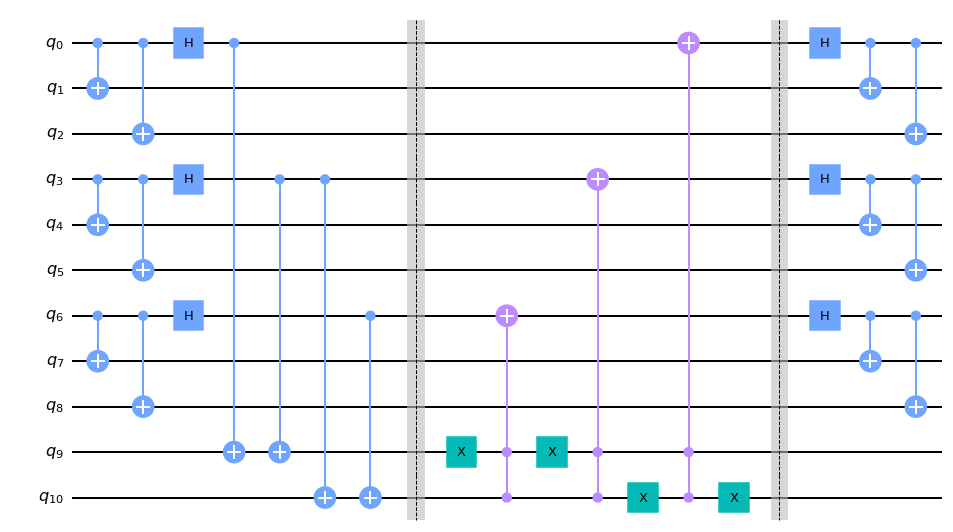

In [63]:
def qc_gen_pf():
    qc = QuantumCircuit(9+2, name = 'PF')
    qc.cx([0], [1]); qc.cx([0], [2]); qc.cx([3], [4]); qc.cx([3], [5]); qc.cx([6], [7]); qc.cx([6], [8]) # destrói o emaranhamento
    qc.h([0, 3, 6]) # destrói a coerência
    qc.cx([0], [9]); qc.cx([3], [9]); qc.cx([3], [10]); qc.cx([6], [10]) # medida de síndrome
    qc.barrier()
    qc.x([9]); qc.ccx([10], [9], [6]); qc.x([9]); qc.ccx([10], [9], [3]); qc.x([10]); qc.ccx([10], [9], [0]); qc.x([10]) # reversão do erro
    qc.barrier()
    qc.h([0, 3, 6]) # passa esses qubits para a base |+>,|->
    qc.cx([0], [1]); qc.cx([0], [2]); qc.cx([3], [4]); qc.cx([3], [5]); qc.cx([6], [7]); qc.cx([6], [8]) # recria o emaranhamento
    return qc
qc_gen_pf_ = qc_gen_pf(); qc_gen_pf_.draw(output = 'mpl')

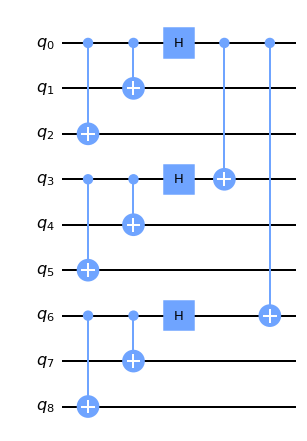

In [74]:
def qc_decoding_shor():
    qc = QuantumCircuit(9, name = 'decoding')
    qc.cx([0], [2]); qc.cx([3], [5]); qc.cx([6], [8])
    qc.cx([0], [1]); qc.cx([3], [4]); qc.cx([6], [7])
    qc.h([0, 3, 6])
    qc.cx([0], [3]); qc.cx([0], [6])
    return qc
qc_decoding_shor_ = qc_decoding_shor(); qc_decoding_shor_.draw(output = 'mpl')

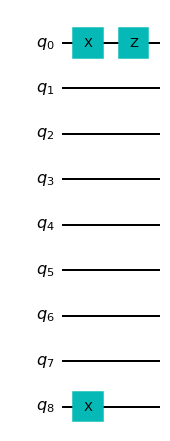

In [89]:
def qc_error():
    qc = QuantumCircuit(9, name = 'error')
    qc.x([0]); qc.z([0])
    #qc.z(4); qc.x([5])
    qc.x([8])
    return qc
qc_error_ = qc_error(); qc_error_.draw(output = 'mpl')

Com isso podemos compor tudo para obter um circuito quântico com $9+6+2=17$ qubits que corrigirá erros únitos, nos trios de qubits, de inversão de bit e/ou inversão de fase. Veja p circuito e testes abaixo.

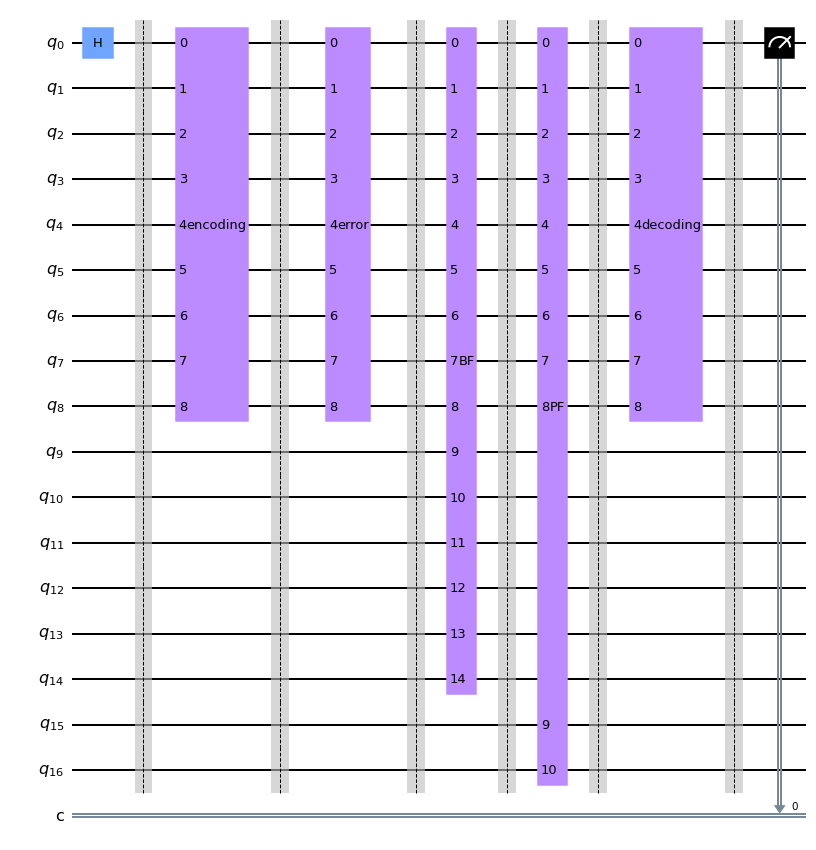

In [90]:
qc = QuantumCircuit(9+6+2, 1)
qc.h([0]) # prepara o estado |1>
qc.barrier()
qc_encoding_shor_ = qc_encoding_shor(); qc.append(qc_encoding_shor_, [0,1,2,3,4,5,6,7,8])
qc.barrier()
qc_error_ = qc_error(); qc.append(qc_error_, [0,1,2,3,4,5,6,7,8])
qc.barrier()
qc_gen_bf_ = qc_gen_bf(); qc.append(qc_gen_bf_, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
qc.barrier()
qc_gen_pf_ = qc_gen_pf(); qc.append(qc_gen_pf_, [0,1,2,3,4,5,6,7,8,15,16])
qc.barrier()
qc_decoding_shor_ = qc_decoding_shor(); qc.append(qc_decoding_shor_, [0,1,2,3,4,5,6,7,8])
qc.barrier()
qc.measure([0], 0)
qc.draw(output = 'mpl')
    

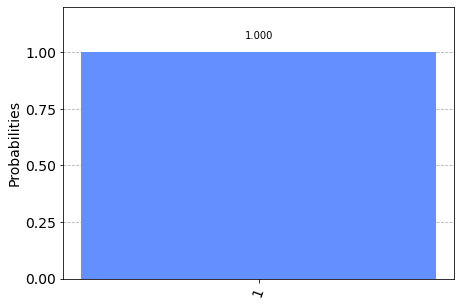

In [85]:
job = execute(qc, backend = simulator, shots = nshots)
plot_histogram(job.result().get_counts(qc))

##### Exercício
Verifique a funcionalidade desse circuito quântico de correção de erros para outras possibilidades de erros.

##### Exercício
Achei, via Google, esse circuito quântico para correção de erros gerais de um qubit. Verificar se ou não esse circuito quântico faz a correção geral.

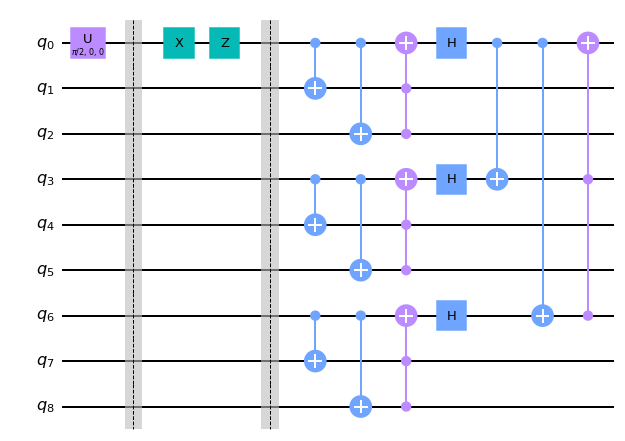

In [38]:

qc = QuantumCircuit(9)
th, ph, lb = math.pi/2, 0.0, 0.0; qc.u(th, ph, lb, [0])

qc.barrier(); qc.x([0]); qc.z([0]); qc.barrier() # o erro
qc.cx([0], [1]); qc.cx([0], [2]); qc.cx([3], [4]); qc.cx([3], [5]); qc.cx([6], [7]); qc.cx([6], [8])
qc.ccx([2], [1], [0]); qc.ccx([5], [4], [3]); qc.ccx([8], [7], [6])
qc.h([0, 3, 6])
qc.cx([0], [3]); qc.cx([0], [6])
qc.ccx([6], [3], [0])
qc.draw(output = 'mpl')

## Mitigação de uma erro geral de um qubit ????

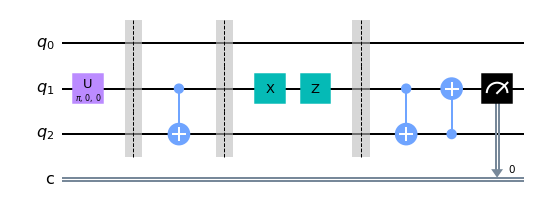

In [88]:
qc = QuantumCircuit(3, 1)
th, ph, lb = math.pi, 0.0, 0.0; qc.u(th, ph, lb, [1]) # state preparation
qc.barrier(); qc.cx([1], [2]); qc.barrier()
qc.x([1]); qc.z([1]); qc.barrier()
qc.cx([1], [2]); qc.cx([2], [1])
qc.measure([1], [0])
qc.draw(output = 'mpl')